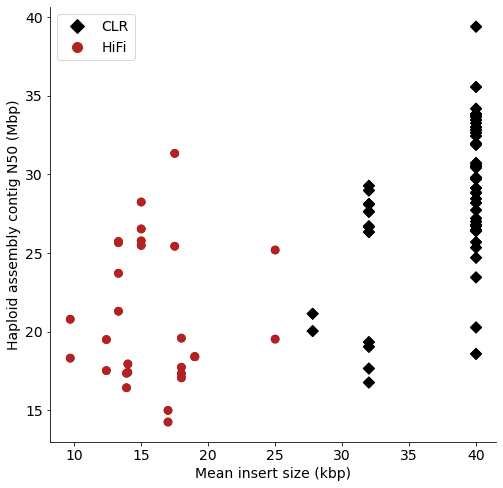

In [17]:
import os
import collections as col
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

save_plot = False
print_stats = False
rel_hap_n50 = False

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

# color_version
# - full
# - super_pop
# - red_black
color_version = 'red_black'

if color_version == 'full' or color_version == 'super_pop':
    rgbcodes['HiFi'] = tuple(map(lambda x: round(x/255, 2), (35, 35, 35)))
    rgbcodes['CLR'] = tuple(map(lambda x: round(x/255, 2), (35, 35, 35)))
elif color_version == 'red_black':
    rgbcodes['HiFi'] = plot_aux.get_platform_color('HiFi')
    rgbcodes['CLR'] = plot_aux.get_platform_color('CLR')
else:
    raise

stats_path = '/home/local/work/data/hgsvc/fig1_panels/contig_stats'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_contiguity-inserts')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))
inserts_cache = '/home/local/work/data/hgsvc/fig1_panels/input_read_stats/insert_sizes.h5'

if not os.path.isfile(cache_file):
    raise RuntimeError('Cannot proceed w/o cached data: {}'.format(cache_file))
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])        

errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')

inserts = pd.read_hdf(inserts_cache, 'cache')
inserts['total_sizes'] = inserts['insert_size'] * inserts['num_cells']
total_cells = inserts.groupby(['sample', 'platform'])['num_cells'].sum()
mean_inserts = inserts.groupby(['sample', 'platform'])['total_sizes'].sum()
mean_inserts /= total_cells
mean_inserts.rename('mean_insert_kbp', inplace=True)
mean_inserts = mean_inserts.round(1)

temp = df.index.copy()

df = df.merge(mean_inserts, how='outer', on=['sample', 'platform'])
df.index = temp

def plot_contiguity_inserts(sample_stats):

    x_vals = col.defaultdict(list)
    y_vals = col.defaultdict(list)
    colors = col.defaultdict(list)
    
    for idx, row in sample_stats.xs('HAP', level='assembly').iterrows():
        platform = idx[3]
        population = idx[2]
        super_pop = idx[1]
        
        insert = row['mean_insert_kbp']
        x_vals[platform].append(insert)
        
        hap1_index = (idx[0], idx[1], idx[2], idx[3], 'HAP', 10)
        hap1_n50 = round(sample_stats.loc[hap1_index, 'N50'] / 1e6, 2)
        if rel_hap_n50:
            hap1_n50 = round(hap1_n50 / sqa_n50, 2)

        y_vals[(platform, 'HAP1')].append(hap1_n50)
        
        hap2_index = (idx[0], idx[1], idx[2], idx[3], 'HAP', 20)
        hap2_n50 = round(sample_stats.loc[hap2_index, 'N50'] / 1e6, 2)
        if rel_hap_n50:
            hap2_n50 = round(hap2_n50 / sqa_n50, 2)
        
        y_vals[(platform, 'HAP2')].append(hap2_n50)
        
        if color_version == 'full':
            colors[platform].append(rgbcodes[population])
        elif color_version == 'super_pop':
            colors[platform].append(rgbcodes[super_pop])
        elif color_version == 'red_black':
            colors[platform].append(rgbcodes[platform])
        else:
            raise
        
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    for platform in plot_aux.get_sequencing_platforms():
        for hap in ['HAP1', 'HAP2']:
            inserts = x_vals[platform]
            hap_n50 = y_vals[(platform, hap)]
            marker_colors = colors[platform]

            axis.scatter(
                inserts,
                hap_n50,
                s=prop('plot_marker_size'),
                c=colors[platform],
                marker=prop('{}_marker'.format(platform))
            )

    axis.set_xlabel(
        'Mean insert size (kbp)',
        fontsize=prop('fontsize_legend')
    )
    if rel_hap_n50:
        axis.set_ylabel(
            'Haploid assembly contig N50 (relative units)',
            fontsize=prop('fontsize_legend')
        )
    else:
        axis.set_ylabel(
            'Haploid assembly contig N50 (Mbp)',
            fontsize=prop('fontsize_legend')
        )
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color=rgbcodes['CLR'],
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR'
        ),
        lines.Line2D(
            [0], [0],
            color=rgbcodes['HiFi'],
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='upper left',
        prop={'size': prop('fontsize_legend')}
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.5, 0.85)
    
    extra_artists = []
    
    return fig, extra_artists
        
fig, exart = plot_contiguity_inserts(df)

if save_plot:
    if color_version == 'red_black':
        out_path += '_rb'
    if color_version == 'super_pop':
        out_path += '_spop'
    if rel_hap_n50:
        output += '_rel'
    fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
    fig.savefig(out_path + '_lowres.png', dpi=150, bbox_inches='tight', extra_artists=exart)
    fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
